# [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/) | DLology

Read my blog post for details.

In [3]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [4]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics

### ClusteringLayer

In [5]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


## Convolutional DEC

In [6]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

### Convolutional auto encoder option 1 using `Conv2DTranspose`

In [7]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Convolutional auto encoder option 2 using `UpSampling2D`

In [8]:
def autoencoderConv2D_2(img_shape=(28, 28, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


### Pick a convolutional autoencoder (`autoencoderConv2D_1` or `autoencoderConv2D_2`)

In [9]:
autoencoder, encoder = autoencoderConv2D_1()

In [10]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              12672     
__________

### Load MNIST data for convolutional input

In [11]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

In [35]:
n_clusters = len(np.unique(y))
x.shape
n_clusters

10

### Pretrain covolutional autoencoder

In [15]:
pretrain_epochs = 1
batch_size = 256
save_dir = 'results/'

In [16]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [17]:
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/1
70000/70000 [==============================] - 18s 256us/step - loss: 0.0614


In [18]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

### Build clustering model with convolutional autoencoder

In [21]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

### Step 1: initialize cluster centers using k-means

In [22]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [23]:
y_pred_last = np.copy(y_pred)

In [24]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering

In [28]:
#computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [25]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [26]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [29]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

Iter 0: acc = 0.37831, nmi = 0.30352, ari = 0.19796  ; loss= 0
Iter 140: acc = 0.38929, nmi = 0.31437, ari = 0.20887  ; loss= 0.12614
Iter 280: acc = 0.39833, nmi = 0.32344, ari = 0.21594  ; loss= 0.17495
Iter 420: acc = 0.41004, nmi = 0.33040, ari = 0.22586  ; loss= 0.19907
Iter 560: acc = 0.41686, nmi = 0.33286, ari = 0.22883  ; loss= 0.21221
Iter 700: acc = 0.41929, nmi = 0.33446, ari = 0.23146  ; loss= 0.21144
Iter 840: acc = 0.42263, nmi = 0.33788, ari = 0.23520  ; loss= 0.21364
Iter 980: acc = 0.42483, nmi = 0.34051, ari = 0.23883  ; loss= 0.22134
Iter 1120: acc = 0.42719, nmi = 0.34094, ari = 0.24185  ; loss= 0.20731
Iter 1260: acc = 0.42791, nmi = 0.34193, ari = 0.24329  ; loss= 0.19927
Iter 1400: acc = 0.42539, nmi = 0.33926, ari = 0.24123  ; loss= 0.23643
Iter 1540: acc = 0.42891, nmi = 0.34398, ari = 0.24670  ; loss= 0.18554
Iter 1680: acc = 0.42936, nmi = 0.34545, ari = 0.24753  ; loss= 0.18219
Iter 1820: acc = 0.42877, nmi = 0.34502, ari = 0.24576  ; loss= 0.1909
Iter 1960

### Load the clustering model trained weights

In [30]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

### Final Evaluation

In [31]:
#Eval.

q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.43440, nmi = 0.36442, ari = 0.25795  ; loss= 0.07341


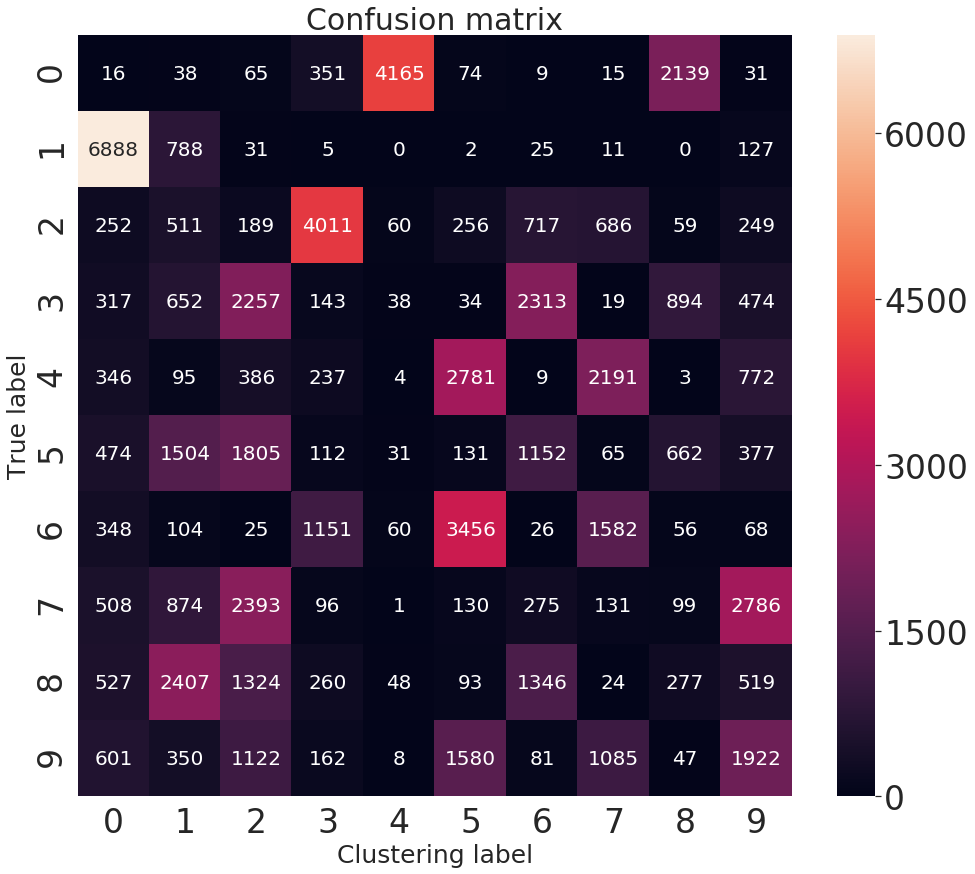

In [34]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()